<a href="https://colab.research.google.com/github/Appendme/big_data_analysis/blob/master/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install csvkit

In [ ]:
import sqlite3 as sql, re, pandas as pd
from matplotlib import pyplot as plt

In [ ]:
!csvsql --db sqlite:///internet_speed.db --insert samples/LA_wifi_speed_UK.csv samples/LA_population.csv

In [ ]:
con = sql.connect('internet_speed.db')
cur = con.cursor()

In [ ]:
query_date = 'SELECT Datetime FROM LA_wifi_speed_UK ORDER BY RANDOM() LIMIT 10'

for row in cur.execute(query_date):
    print(row)

('2016-12-08 19:00:00.000000',)
('2016-12-01 22:00:00.000000',)
('2016-12-02 04:00:00.000000',)
('2016-11-28 16:30:00.000000',)
('2016-12-06 14:30:00.000000',)
('2016-12-03 03:00:00.000000',)
('2016-11-23 15:30:00.000000',)
('2016-12-08 13:30:00.000000',)
('2016-12-10 19:30:00.000000',)
('2016-12-05 01:30:00.000000',)


In [ ]:
query_desc = 'SELECT * FROM LA_wifi_speed_UK LIMIT 1'
col = [n[0] for n in cur.execute(query_desc).description]
col = col[1:]
col = [re.sub(r'_\w', '', c) for c in col]
col = list(set(col))
col.remove('DateTime')

Text(0.5, 1.0, 'E07000202')

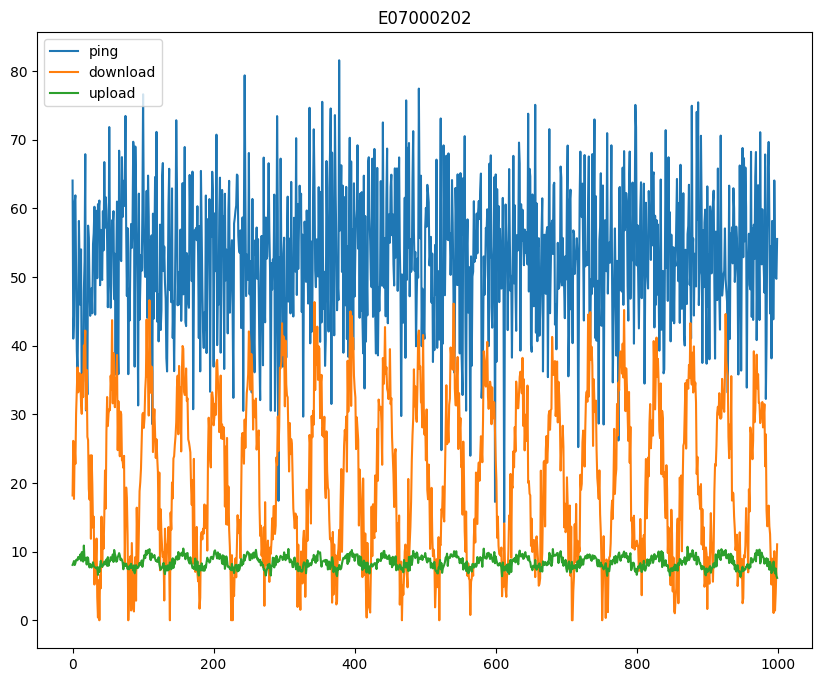

In [ ]:
plt.figure(figsize = (10, 8))
suffix = {'_p':'ping', '_d':'download', '_u':'upload'}

for (k, v) in suffix.items():
    cur.execute(f'SELECT {col[0]}{k} FROM LA_wifi_speed_UK ORDER BY DateTime')
    plt.plot(cur.fetchall(), label = v)

plt.legend()
plt.title(col[0])

In [ ]:
df = pd.DataFrame(columns=['Area', 'Average_p', 'Average_d', 'Average_u'])
rows = []

for c in col:
    l = [c]
    for k, v in suffix.items():
        cur.execute(f'SELECT AVG({c + k}) FROM LA_wifi_speed_UK')
        l.append(cur.fetchone()[0])

    rows.append(l)

df = pd.concat([df, pd.DataFrame(rows, columns=df.columns)], ignore_index=True)

df.head()


<ipython-input-30-8f600648b3f4>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(rows, columns=df.columns)], ignore_index=True)


,Area,Average_p,Average_d,Average_u
0,E07000202,52.818290,21.314812,8.476300
1,E07000213,51.764906,21.206035,8.358611
2,E07000105,51.807182,21.145754,8.432119
3,E07000036,51.806028,21.159820,8.430822
4,E06000025,54.996403,22.207129,8.988448


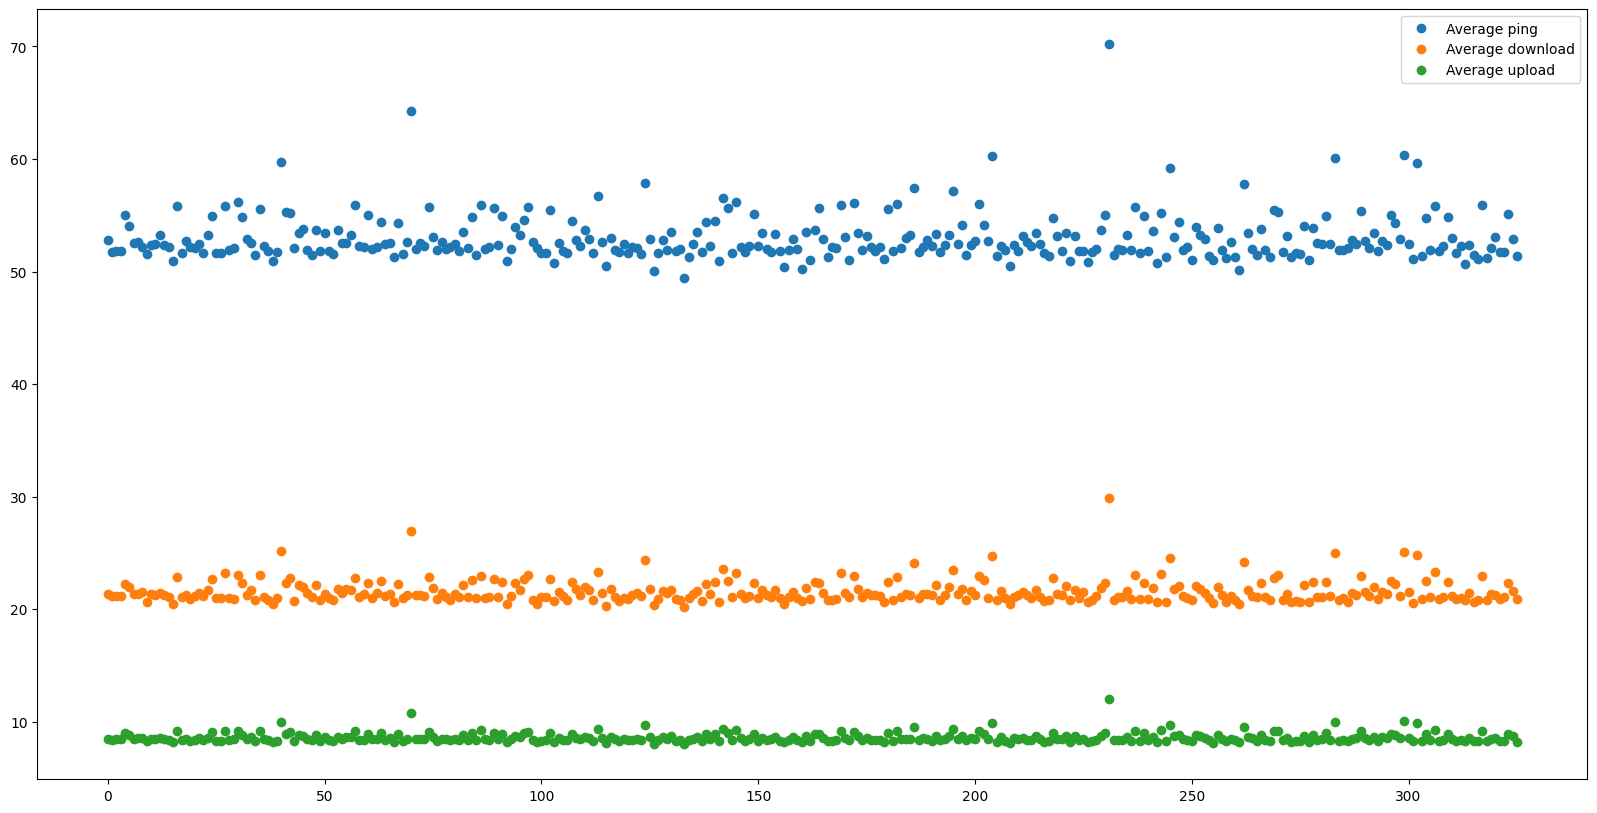

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(df.index, df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])

In [ ]:
try:
    cur.execute('DROP TABLE average_speed')
except:
    pass

df.to_sql('average_speed', con)

326

In [ ]:
for r in cur.execute('SELECT * FROM average_speed').fetchmany(4):
    print(r)

(0, 'E07000202', 52.818289625070584, 21.31481162947925, 8.47630007709408)
(1, 'E07000213', 51.76490557765866, 21.206034774941795, 8.358610663733037)
(2, 'E07000105', 51.80718221466102, 21.145754324646802, 8.432118849908598)
(3, 'E07000036', 51.806028277244486, 21.159819934866697, 8.430821714940361)


In [ ]:
cur.execute('SELECT * FROM average_speed JOIN LA_population ON average_speed.Area = LA_population.LA_code')
for r in cur.fetchmany(4):
    print(r)

(0, 'E07000202', 52.818289625070584, 21.31481162947925, 8.47630007709408, 'Ipswich', 'E07000202', 133384.0)
(1, 'E07000213', 51.76490557765866, 21.206034774941795, 8.358610663733037, 'Spelthorne', 'E07000213', 95598.0)
(2, 'E07000105', 51.80718221466102, 21.145754324646802, 8.432118849908598, 'Ashford', 'E07000105', 117956.0)
(3, 'E07000036', 51.806028277244486, 21.159819934866697, 8.430821714940361, 'Erewash', 'E07000036', 112081.0)


In [ ]:
query = '''
SELECT Area, Average_p, Average_d, Average_u, Total_Population
FROM average_speed
JOIN LA_population ON average_speed.Area = LA_population.LA_code
'''
cur.execute(query)

# Получаем данные из запроса
data = cur.fetchall()

# Создаём DataFrame напрямую
df = pd.DataFrame(data, columns=['Area', 'Average_p', 'Average_d', 'Average_u', 'Population'])

df.head()


,Area,Average_p,Average_d,Average_u,Population
0,E07000202,52.818290,21.314812,8.476300,133384.0
1,E07000213,51.764906,21.206035,8.358611,95598.0
2,E07000105,51.807182,21.145754,8.432119,117956.0
3,E07000036,51.806028,21.159820,8.430822,112081.0
4,E06000025,54.996403,22.207129,8.988448,262767.0


In [ ]:
sorted_asc = df.sort_values(['Population'])
sorted_asc.head()

,Area,Average_p,Average_d,Average_u,Population
126,E06000053,50.084966,20.358606,8.004334,2203.0
133,E09000001,49.384769,20.165312,8.047228,7375.0
115,E07000191,50.492327,20.280303,8.154217,34675.0
255,E06000017,50.992436,20.572656,8.153301,37369.0
208,E07000051,50.481485,20.484920,8.152685,44973.0


In [ ]:
sorted_dsc = df.sort_values(['Population'], ascending = False)
sorted_dsc.head()

,Area,Average_p,Average_d,Average_u,Population
231,E08000025,70.192955,29.853411,11.999448,1073045.0
70,E08000035,64.302549,26.995125,10.790424,751485.0
299,E08000019,60.352773,25.068847,10.052675,552698.0
40,E06000052,59.742131,25.161968,9.963647,532273.0
283,E08000032,60.068885,24.982134,9.982742,522452.0


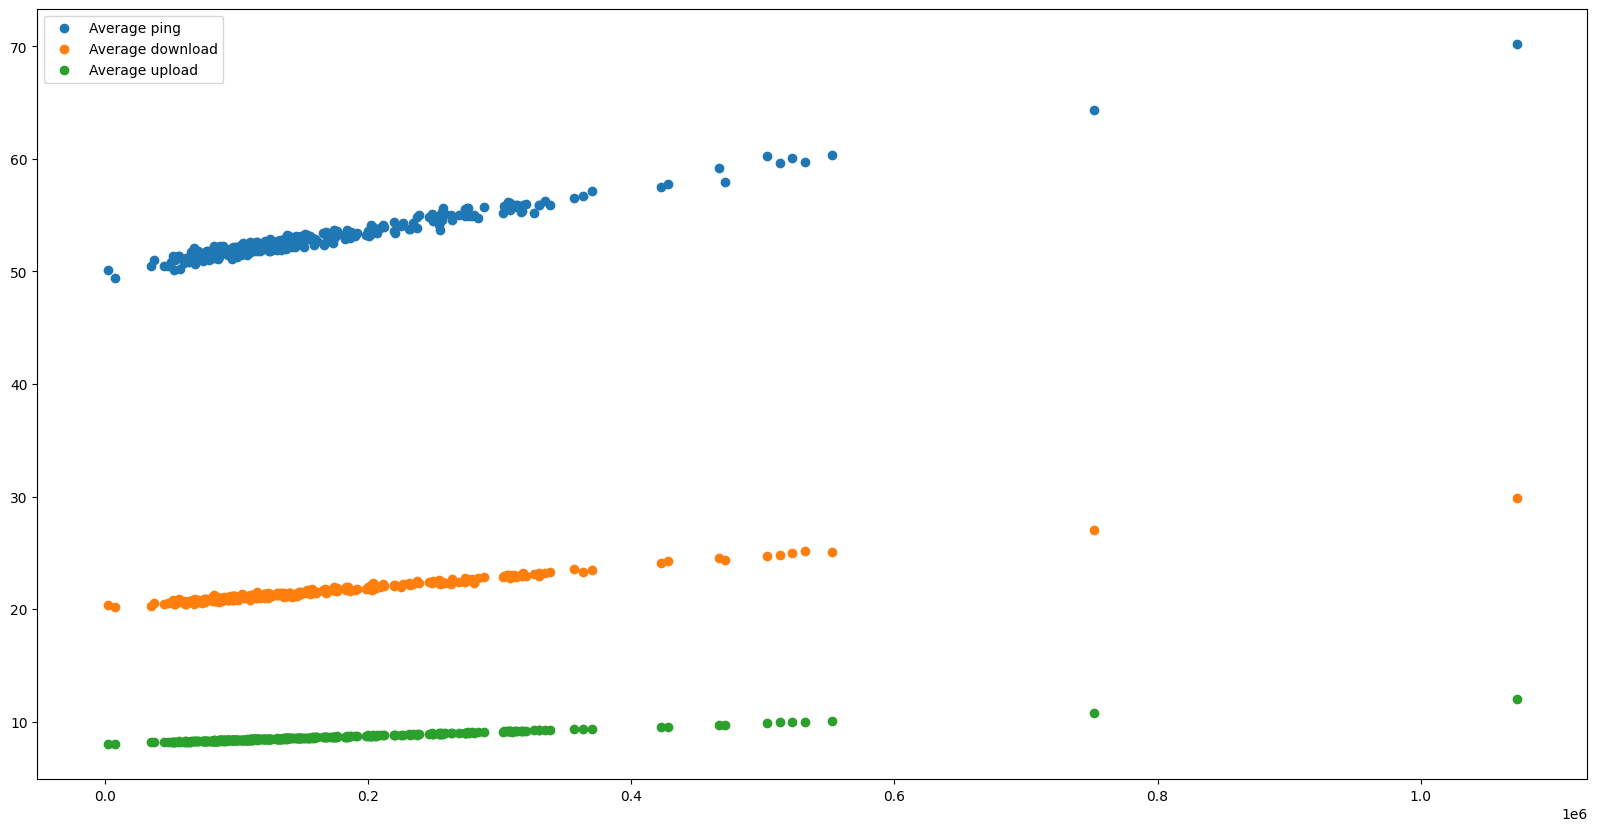

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(df['Population'], df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])

# по графику ниже можно увидеть что средняя скорость не зависит от плотности населения, но при этом средняя задержка увеличивается

Что такое csvsql, как она работает?
Генерирует SQL запросы для создания баз данных.

Можно ли объединить таблицы в базе данных, как это сделать?
Объединение осуществляется встроенной функцией SQL - JOIN

Какой метод Pandas позволяет добавлять информацию в базу данных?
Метод append от типа pd.DataFrame

Что делает метод fetchall ()?
Возвращает список всех строк полученных при запросе к БД

Почему для обработки данных используется библиотека Pandas, можно ли выполнить такую же обработку другим способом?
Pandas имеет удобное и готовое API для работы с данными. Без использования этой библиотеки пришлось бы преобразовывать полученные строки с БД в структуры питона для дальнейшей передачи в библиотеку matplotlib.